In [ ]:
import numpy as np
import pandas as pd
import re

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

data = pd.read_csv('data/data_keep_50000.csv', low_memory=False)
train_df = pd.read_csv('data/meinian_round1_train_20180408.csv')
test_df = pd.read_csv('data/meinian_round1_test_a_20180409.csv')

# 通过 describe 查看特征的类型，标准差，修正类型和异常数据
train_df['收缩压'] = pd.to_numeric(train_df['收缩压'], errors='coerce')
train_df['舒张压'] = pd.to_numeric(train_df['舒张压'], errors='coerce')
train_df.loc[22712, '血清甘油三酯'] = 7.75
train_df['血清甘油三酯'] = pd.to_numeric(train_df['血清甘油三酯'], errors='coerce')
# train_df['舒张压'].sort_values(ascending=False)[:5]
train_df.loc[22357, '舒张压'] = np.nan
train_df.loc[29394, '舒张压'] = np.nan
train_df.loc[29394, '收缩压'] = np.nan

In [ ]:
# 合并数据
merged_train_df = pd.merge(train_df, data, on='vid', sort=False)
merged_test_df = pd.merge(test_df, data, on='vid', sort=False)
combine = [merged_train_df, merged_test_df]

In [ ]:
print(merged_train_df.info())

In [ ]:
# 提取数值特征(大于0.5)
numerical_feature = []

def get_num_prop(data_col):
    num_counts = data_col.astype(
        str).str.match(r'^(-?\d+)(\.\d+)?$').sum()
    na_counts = data_col.isna().sum()
    return num_counts / (data_col.shape[0] - na_counts)

for col in merged_train_df.columns.values:
    if get_num_prop(merged_train_df[col]) > 0.5:
        numerical_feature.append(col)

label = numerical_feature[0:5]        
numerical_feature = numerical_feature[5:]
print('numerical feature count: %s' %len(numerical_feature))
print(numerical_feature)

In [ ]:
def search_non_numeric(data):
    if not re.search(r'^(-?\d+)(\.\d+)?$', data) and data!='nan':
        non_numeric.append(data)

non_numeric = []
# applymap 会有问题，第一列会操作两次
for col in numerical_feature:
    non_numeric.append('----'+col+'----')
    temp = merged_train_df[col].astype('str').apply(search_non_numeric)
for col in numerical_feature:
    non_numeric.append('----'+col+'----')
    temp = merged_test_df[col].astype('str').apply(search_non_numeric)

In [ ]:
len(non_numeric)

In [ ]:
with open('mix_in_numeric.txt', 'w') as f:
    for t in non_numeric:
        f.write(t+'\n')

In [ ]:
def print_non_num(feature_series):
    print(feature_series[feature_series.str.match(r'^(-?\d+)(\.\d+)?$')==False])

In [ ]:
def convert_mixed_num(data):
    data = data.strip()
    special_cases = ['未见','阴性']
    try:
        ret = float(data)
        return ret
    except:
        if data in special_cases:
            return 0
        all_match = re.findall(r'\d+\.?\d*', data) # 注意：不带负号
        if all_match:
            all_list = [float(i) for i in all_match]
            return sum(all_list)/len(all_list)    # 取均值
        else:
            return np.nan

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

test = merged_train_df['300017'].astype(
        'str').apply(convert_mixed_num).dropna()
sns.distplot(test)
plt.show()

In [ ]:
print_non_num(merged_test_df['1840'])

In [ ]:
merged_train_df.loc[32230,'1850'] = 3.89
merged_train_df.loc[[2527,3027],'192'] = 16.07, 12.01
merged_train_df.loc[3163,'193'] = np.nan
merged_train_df.loc[6055,'2333'] = 5.0    # 多了小数点
merged_train_df.loc[5085,'269013']    # 未见，映射成0
merged_train_df.loc[[8551,8840,9072,9309],'3193'] = '>=1.030'

merged_test_df.loc[2327, '3193'] = '>=1.030'
merged_test_df.loc[2327, '1840'] = '<=5.0'

In [ ]:
for df in combine:
    df[numerical_feature] = df[numerical_feature].astype(
        'str').applymap(convert_mixed_num)

In [ ]:
label_numerical_df = merged_train_df[label + numerical_feature]

In [ ]:
# corr = label_numerical_df.corr()
# sns.pairplot(corr)

In [ ]:
# plt.show()

In [26]:
merged_train_df.describe()

,收缩压,舒张压,血清甘油三酯,血清高密度脂蛋白,血清低密度脂蛋白,0424,100005,100006,100007,100014,10002,10003,10004,1106,1107,1115,1117,1127,1321,1322,1325,1326,1345,139,143,1474,155,1814,1815,183,1840,1845,1850,190,191,192,193,2174,2333,2372,2403,2404,2405,2406,2420,269003,269004,269005,269006,269007,269008,269009,269010,269011,269012,269013,269014,269015,269016,269017,269018,269019,269020,269021,269022,269023,269024,269025,300017,300021,31,312,313,314,315,316,317,319,3193,32,320,33,34,37,38,39,669001,669002,669006,809001,809009,979001,979002,979003,979004,979005,979006,979007,979008,979009,979011,979012,979013,979014,979015,979016,979017,979018,979019,979020,979021,979022,979023
count,38191.000000,38190.000000,38158.000000,38199.000000,38199.000000,30270.000000,12899.000000,17473.000000,15043.000000,4938.000000,20113.000000,18408.000000,34717.000000,5705.000000,5568.000000,22979.000000,26085.000000,8222.000000,17015.000000,17009.000000,6293.000000,6287.000000,9234.000000,5666.000000,5427.000000,5080.000000,8820.000000,38018.000000,36194.000000,20705.000000,36665.000000,17145.000000,35078.000000,37461.000000,37082.000000,29808.000000,25799.000000,20210.000000,17493.000000,17349.000000,36776.000000,36777.000000,36609.000000,13217.000000,9775.000000,8218.000000,8362.000000,8058.000000,8219.000000,7288.000000,8219.000000,8219.000000,8219.000000,7980.000000,8219.000000,8249.000000,8215.000000,8359.000000,8215.000000,8219.000000,8363.000000,8219.000000,8363.00000,8362.000000,8362.000000,8362.000000,8362.000000,8316.000000,5058.000000,5829.000000,17712.000000,17571.000000,17459.000000,22234.000000,17712.000000,17712.000000,17459.000000,17712.000000,36638.000000,17553.000000,16938.000000,17409.000000,13957.000000,17712.000000,17712.000000,14101.000000,5289.000000,5367.000000,5160.000000,5649.000000,4858.000000,6832.000000,6704.000000,6869.000000,6870.000000,6286.000000,6615.000000,6870.000000,6870.000000,6870.000000,6870.000000,6905.000000,6767.000000,6767.000000,6870.000000,6871.000000,6870.000000,6766.000000,6766.000000,6870.000000,6871.000000,6870.000000,6870.000000
mean,126.052918,77.023619,1.612536,1.406683,2.769719,72.888128,18.969464,14.448569,0.687269,15.415094,9.183797,28.616702,4.787489,1.450423,0.957126,75.152059,34.423413,118.552245,0.817170,0.826037,0.916013,0.919260,173.631159,1.592666,13.674605,93.227131,2.272346,28.540822,23.668469,75.250600,6.114276,1.664133,5.278316,70.512614,333.618480,13.249230,4.064471,46.600614,1.724999,3.318521,68.275377,165.120286,24.929351,58.049584,78.198271,15.227035,9.235608,0.196681,214.206473,46.271937,340.019601,30.710196,90.245711,42.113750,145.770288,4.739366,3.714734,0.397310,1.802418,60.325677,6.579583,30.182888,6.09749,2.694310,0.233265,0.165098,0.012579,13.340669,1.100812,10.139740,4.736107,6.257604,143.232866,38.991491,90.603513,30.289683,334.513494,215.117475,1.019033,3.768755,9.410126,2.076115,0.426795,57.697587,30.840653,7.730919,3.513815,1.484888,7.259435,6.435024,1.620080,15.403295,0.192409,9.230496,214.194367,12.153151,39.875247,325.288295,30.151803,91.503314,142.016303,4.766898,0.032273,0.154203,3.520148,0.354890,2.060746,0.547857,2.497774,56.981725,5.831713,34.172217,6.120060
std,19.265082,13.385752,1.335518,0.341184,0.852217,9.084214,12.073726,2.659313,4.187223,5.406276,4.083286,4.205664,9.768690,0.260296,0.247000,24.124697,41.350377,156.293794,0.375756,0.374986,0.276034,0.271517,32.366895,0.541051,7.735491,31.729177,2.853174,25.615856,14.002039,4.850341,0.693084,0.289807,1.335770,18.377908,94.177682,5.520909,2.299311,3.148518,2.616296,5.314787,297.903978,8.684456,112.334889,7.946809,11.335366,3.243515,1.476703,0.130491,55.690242,4.622187,15.234826,2.594303,6.180244,7.322649,17.252298,0.585971,1.277855,0.149939,0.610732,8.814129,1.976209,8.304851,1.61659,2.199148,0.334817,0.161030,0.021401,1.652563,1.385793,8.359404,0.523044,1.620847,16.772720,13.188444,6.050279,2.471872,15.049161,55.691769,0.039605,1.258986,1.791910,0.737653,0.209125,13.335674,10.749796,6.360497,3.364076,1.251068,6.600688,3.904337,0

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


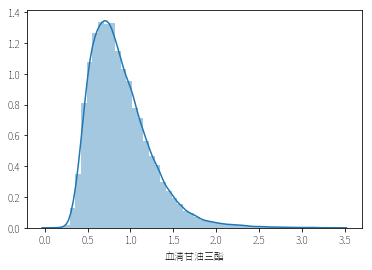

In [37]:
test = np.log1p(merged_train_df['血清甘油三酯'].dropna())
sns.distplot(test)
plt.show()

In [ ]:
# %matplotlib inline
# fig = plt.gcf()
# fig.set_size_inches(18, 18)
# sns.heatmap(merged_train_df[label+numerical_feature].corr())
# plt.show()